# Chapter 4: The Quest for Best Estimators


## 4.1. Voting Ensembles: An Overview

Voting ensembles are a powerful technique in machine learning where the predictions from multiple models are aggregated to produce a single, more robust prediction. The core idea is to combine the strengths of various base models to improve overall performance, mitigate individual weaknesses, and achieve greater generalization. In the particular case of our project, we are going to aggregate the results of the best_rf, best_xgb, and best_ada models using three techniques: hard voting, soft voting, and stacking. Before we dive into the code of the training, it is useful to review aspects of these ensemble techniques. 

### Why Use Voting Ensembles?

- **Improved Performance**: By aggregating predictions, voting ensembles often achieve higher accuracy, precision, and recall compared to individual models.
- **Robustness**: They reduce the risk of overfitting since errors from one model can be compensated by others.
- **Flexibility**: Voting ensembles can be constructed from a diverse set of models (e.g., logistic regression, tree-based models, boosting methods) to leverage their complementary strengths.

### Advantages of Voting Ensembles

- **Simplicity**: Easy to implement and interpret, especially in comparison to more complex techniques like stacking or blending.
- **Diversity**: Aggregating predictions from diverse models increases robustness and reduces variance.
- **Reduced Risk**: Mitigates the impact of poor predictions from individual models.

### Disadvantages of Voting Ensembles

- **Computational Cost**: Training and maintaining multiple models can be resource-intensive.
- **Performance Limitations**: The ensemble’s performance is limited by the quality and diversity of its base models. If the models are too similar, the ensemble may not add significant value.
- **Bias Sensitivity**: If the base models share similar biases, the ensemble may inherit them.

#### Types of Voting Ensembles

1. **Hard Voting**:
   - Each model casts a "vote" for a specific class label, and the class with the majority of votes is chosen as the final prediction.
   - Mathematically: $y_{\text{final}} = \text{mode}\left(\{y_1, y_2, ..., y_n\}\right)$
     where $y_1, y_2, ..., y_n$ are the predictions from \(n\) base models.
   - **Use Case**: Works well when models produce strong and diverse predictions.

2. **Soft Voting**:
   - Instead of class labels, the predicted probabilities from each model are averaged, and the class with the highest averaged probability is selected.
   - Mathematically: $\hat{P}(y = c) = \frac{1}{n} \sum_{i=1}^n P_i(y = c)$
     where $P_i(y = c)$ is the predicted probability for class $c$ from model $i$, and $n$ is the number of models.
   - **Use Case**: Particularly effective when models are well-calibrated, as it allows the ensemble to weigh the confidence of predictions.

3. **Weighted Voting** (Extension of Soft Voting):
   - Assigns weights to models based on their performance or reliability, with higher weights given to better-performing models.
   - Mathematically: $\hat{P}(y = c) = \frac{\sum_{i=1}^n w_i P_i(y = c)}{\sum_{i=1}^n w_i}$
     where $w_i$ is the weight assigned to model $i$.
   - **Use Case**: Useful when some models are known to perform better or are more reliable in certain contexts.

By understanding these types of voting ensembles, practitioners can select or design ensembles tailored to their specific needs and datasets, balancing the trade-offs between simplicity, computational cost, and predictive performance.

### Key Considerations for Voting

#### 1. Diversity of Models
The success of a voting ensemble depends on the diversity of its base models. Diversity can stem from:
- **Algorithmic Differences**: Employing distinct learning algorithms (e.g., boosting vs. bagging).
- **Focus Areas**: Models that complement each other’s weaknesses (e.g., a high-recall model with a high-precision model).

In this setup, the inclusion of Random Forest introduces diversity through bagging, while XGBoost and AdaBoost bring in distinct boosting mechanisms.

#### 2. Voting Mechanisms
- **Hard Voting**: Uses the majority class label as the final prediction. This is particularly useful when models provide discrete and conflicting outputs.
- **Soft Voting**: Aggregates the predicted probabilities of all models, offering smoother and often more accurate predictions, especially when the models are well-calibrated.

### Our Choice of Base Models

In the previous chapter, we observed that boosting models, particularly XGBoost and AdaBoost, demonstrated exceptional performance in both recall and precision. However, calibration analysis revealed that while AdaBoost achieves strong recall, it is not as confident in its predictions as XGBoost. Additionally, the best Random Forest model achieved significantly high precision and demonstrated excellent confidence in its outputs.

To introduce diversity into the ensemble voting process, we opted to combine these three promising models:
- **XGBoost**: For its superior recall and well-calibrated probability estimates.
- **AdaBoost**: For its adaptive focus on difficult cases, complementing XGBoost's strengths.
- **Random Forest**: For its robustness and precision which dds diversity to the ensemble through a bagging mechanism.

### Expected Outcomes of Voting Ensembles

When employing ensemble voting, we expect:
- **Marginal Improvements in Metrics**: Precision and recall may improve by a few percentage points compared to the individual base models.
- **Trade-offs Between Metrics**: While it is unlikely that the voting ensemble will outperform all base models simultaneously across all metrics, we anticipate that it will outperform individual models in at least one dimension (either recall or precision).

By leveraging the complementary strengths of these base models, the ensemble aims to strike a balance between recall and precision while improving robustness and reliability in predictions.

## 4.2. Training Hard and Soft Voting Ensembles

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# extract parameters from best estimators
best_rf_params = best_estimators_dict['best_rf'].get_params()
best_ada_params = best_estimators_dict['best_ada'].get_params()
best_xgb_params = best_estimators_dict['best_xgb'].get_params()

# manually initialize the base estimator (DecisionTreeClassifier)
ada_base_estimator = DecisionTreeClassifier(
    max_depth=6,
    max_features=0.6,
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    splitter='best'
)

# manually initialize the AdaBoost classifier
ada_model = AdaBoostClassifier(
    estimator=ada_base_estimator,
    algorithm='SAMME',
    learning_rate=1,
    n_estimators=100,
    random_state=42
)

# define fresh, untrained models
rf_model = RandomForestClassifier(**best_rf_params)
xgb_model = XGBClassifier(**best_xgb_params)

# create voting classifiers
voting_hard = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('ada', ada_model),
        ('xgb', xgb_model)
    ],
    voting='hard'
)

# fit voting classifiers (training all constituent models here)
voting_hard.fit(X_train, y_train_8)

In [ ]:
voting_soft = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('ada', ada_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

voting_soft.fit(X_train, y_train_8)

## 4.2.1. Evaluation of the Voting Models: An Overview

In [112]:
voting_dict = {"hard_voting": voting_hard, "soft_voting": voting_soft}

voting_results = evaluate_best_estimators(voting_dict, validation_X_train, validation_y_8)

voting_summary = create_summary_table(voting_results)


Evaluating hard_voting...
Generating predictions for hard_voting...
ROC AUC cannot be calculated for hard_voting: Model does not provide probabilities.

Evaluating soft_voting...
Generating predictions for soft_voting...


In [113]:
voting_bases = ["best_rf", "best_xgb", "best_ada"]

tuned_summary_voting_base = tuned_summary.loc[tuned_summary["Model"].isin(voting_bases)]

individual_ensembles_and_voting = pd.concat([voting_summary,tuned_summary_voting_base])

The voting ensembles show an 8% improvement in recall compared to the Random Forest, demonstrating their ability to address its key weakness. However, both ensembles exhibit slightly lower precision than the Random Forest. Compared to the boosting models, the ensembles achieve a marginal improvement in precision while maintaining slightly lower recall. This outcome aligns with expectations for voting models, which aim to balance the strengths of their base models and often enhance overall performance at the cost of slight trade-offs in individual metrics.

#### Why no ROC Score for Hard Voting
Hard voting aggregates class labels from base models, selecting the majority prediction without using probabilities. Since ROC AUC relies on ranking instances by predicted probabilities, it cannot be computed for hard voting. While approximation methods exist, they are not standard practice and are generally not recommended for robust evaluation

## 4.3. Stacking Ensemble

### An Overview

**What is Stacking?**  
Stacking, or stacked generalization, is an ensemble learning technique that combines predictions from multiple base models (referred to as level-0 models) using a meta-model (level-1 model). The meta-model is trained to optimize the final predictions based on the outputs of the base models, effectively learning how to best combine their strengths. Here is ***how stacking generally works:***  
1. **Base Models Training (Level-0):**  
   Each base model is trained on the original training data, producing predictions. These models can differ in algorithms, architectures, or hyperparameter configurations to ensure diversity.
   
2. **Meta-Model Training (Level-1):**  
   - The meta-model is trained on the predictions (or probabilities) generated by the base models. The target labels are used during this training.  
   - Typically, cross-validation is used to prevent overfitting and ensure the meta-model does not directly memorize the outputs of the base models.

3. **Final Prediction:**  
   The meta-model combines the predictions of the base models to produce a final output.

**General Advantages of Stacking:**  
- **Improved Performance:** By leveraging the strengths of diverse models, stacking can outperform individual models and simple voting ensembles.  
- **Flexibility:** Base models and the meta-model can be of different types, allowing a highly customized ensemble.  
- **Adaptability:** The meta-model can learn complex relationships between the outputs of the base models, making stacking highly versatile.

**General Disadvantages of Stacking:**  
- **Complexity:** Stacking is computationally expensive and requires additional training for the meta-model.  
- **Overfitting Risk:** Without careful cross-validation, the meta-model may overfit to the predictions of the base models.  
- **Interpretability:** Stacking ensembles are less interpretable than simpler models, as the meta-model's logic depends on the outputs of diverse base models.  

**When to Use Stacking:**   stacking is perhaps most effective when: (a) base models are diverse and individually strong, (b) sufficient computational resources are available, and (c) Higher achievements on metrics (e.g. accuracy, F1-score etc) justifies the added complexity. 

### 4.3.1. Training a Stack Ensemble

The following code trains a stacking model based on the best estimators for Random Forest, AdaBoost, and XGBoost which we obtained from Chapter 3.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

best_rf = best_estimators_dict["best_rf"]
best_xgb = best_estimators_dict["best_xgb"]
best_ada = best_estimators_dict["best_ada"]

base_models = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "AdaBoost": best_ada
}

def generate_meta_features(models, X, y, n_splits=5):
    """
    generate meta-features using out-of-fold predictions from base models.

    args:
        - models (dict): Dictionary of base models.
        - X (ndarray): Feature data.
        - y (ndarray): Target labels.
        - n_splits (int): Number of splits for out-of-fold predictions.

    returns: 
        - meta_features (ndarray): Predictions from base models.
        - meta_targets (ndarray): True labels for meta-model training.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    meta_features = np.zeros((X.shape[0], len(models)))  # Each model produces one feature
    meta_targets = y  # True labels

    for i, (model_name, model) in enumerate(models.items()):
        print(f"Generating meta-features for {model_name}...")
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold = y[train_idx]
            model.fit(X_train_fold, y_train_fold)
            meta_features[val_idx, i] = model.predict_proba(X_val_fold)[:, 1]  # Use probabilities

    return meta_features, meta_targets

# generate meta-features using out-of-fold predictions
X_meta, y_meta = generate_meta_features(base_models, X_train, y_train_8)

# train the Gradient Boosting meta-model
meta_model = GradientBoostingClassifier(random_state=42)
meta_model.fit(X_meta, y_meta)

# validate the Stacking Model
X_validation_meta = np.column_stack([model.predict_proba(X_train)[:, 1] for model in base_models.values()])
y_pred_meta = meta_model.predict(X_validation_meta)

### 4.3.2. Evaluating The Stack Ensemble on the Hold-out Validation Set

Let us examine how the stack model performs on the validation set.

In [115]:
def evaluate_stacked_model(base_models, meta_model, test_features, test_labels, positive_class=8):
    """
    evaluate a stacking model by generating predictions from base models, stacking them,
    and using the meta-model for final predictions.

    args:
    - base_models (dict): Dictionary of trained base models.
    - meta_model (estimator): Trained meta-model.
    - test_features (ndarray): Feature data for testing.
    - test_labels (ndarray): True labels for testing.
    - positive_class (int): The class considered positive (default: 8).

    returns:
    - dict: Evaluation metrics including precision, recall, F1-score, accuracy, ROC-AUC, and confusion matrix.
    """
    # step 1: Generate predictions from base models
    base_predictions = []
    for model in base_models.values():
        base_predictions.append(model.predict_proba(test_features)[:, 1])  # Probability of positive class
    
    # step 2: Stack the predictions to create new features
    meta_features = np.column_stack(base_predictions)

    # step 3: Predict using the meta-model
    stacked_predictions = meta_model.predict(meta_features)
    stacked_probabilities = meta_model.predict_proba(meta_features)[:, 1]

    # convert test labels to binary format for the positive class
    binary_test_labels = (test_labels == positive_class)

    # step 4: Evaluate the meta-model
    precision = precision_score(binary_test_labels, stacked_predictions)
    recall = recall_score(binary_test_labels, stacked_predictions)
    f1 = f1_score(binary_test_labels, stacked_predictions)
    accuracy = accuracy_score(binary_test_labels, stacked_predictions)
    conf_matrix = confusion_matrix(binary_test_labels, stacked_predictions)
    fpr, tpr, _ = roc_curve(binary_test_labels, stacked_probabilities)
    roc_auc = auc(fpr, tpr)

    # return the evaluation metrics
    return ({
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy,
        "ROC AUC": roc_auc},
        conf_matrix)

In [117]:
##### compute the results on the validation set
validation_results = evaluate_stacked_model(
    base_models=base_models,
    meta_model=meta_model,
    test_features=validation_X_train,
    test_labels=validation_y,
    positive_class=8
)

stack_summary = pd.DataFrame(validation_results[0], index=["stack"])
stack_summary

,Precision,Recall,F1-Score,Accuracy,ROC AUC
stack,0.981744,0.968,0.974824,0.995,0.999571


## 4.4. Comparison of Stacking and Voting Ensembles

The summary table below, along with the accompanying bar chart, provides a comparative overview of the performance of the stacking ensemble, voting models (hard and soft), and the base tree-based ensembles (Random Forest, XGBoost, and AdaBoost). These results reaffirm certain expectations: while the stacking and voting models excel in specific metrics, they do not outperform consistently across all dimensions.

The stacking model, leveraging Gradient Boosting as its meta-model, demonstrates superior performance in **recall**, outperforming the best Random Forest, XGBoost, and AdaBoost from the previous chapter. However, this improvement in recall comes at a slight cost in **precision**, where the three base models achieve marginally higher values. This highlights the trade-offs inherent in ensemble learning—while stacking effectively captures more negative cases, it slightly sacrifices its ability to maintain higher precision.

In contrast, both the hard and soft voting models benefit from the aggregation mechanism inherent in voting. This mechanism amplifies the **precision**, particularly by incorporating the high-precision nature of the Random Forest. However, the same mechanism causes a drop in **recall**, as the low recall of the Random Forest influences the ensemble's overall performance. This is a common trade-off observed in voting systems where the aggregation can strengthen certain aspects while weakening others.

Ultimately, the choice between stacking and voting models depends on the specific business objectives and the performance metric deemed most critical. For tasks prioritizing **recall**, the stacking model emerges as a strong contender. Conversely, if **precision** is paramount, the voting models—particularly soft voting—offer a more suitable alternative.

In [118]:
individual_ensembles_and_voting.index = individual_ensembles_and_voting["Model"]
individual_ensembles_and_voting.drop(columns=["Model"], inplace=True)
ensembles_results_comparison = pd.concat([stack_summary, individual_ensembles_and_voting])
ensembles_results_comparison

,Precision,Recall,F1-Score,Accuracy,ROC AUC
stack,0.981744,0.968,0.974824,0.9950,0.999571
hard_voting,0.988530,0.948,0.967841,0.9937,NaN
soft_voting,0.988494,0.945,0.966258,0.9934,0.999478
best_ada,0.983623,0.961,0.972180,0.9945,0.999396
best_xgb,0.985567,0.956,0.970558,0.9942,0.999505
best_rf,0.990857,0.867,0.924800,0.9859,0.998330


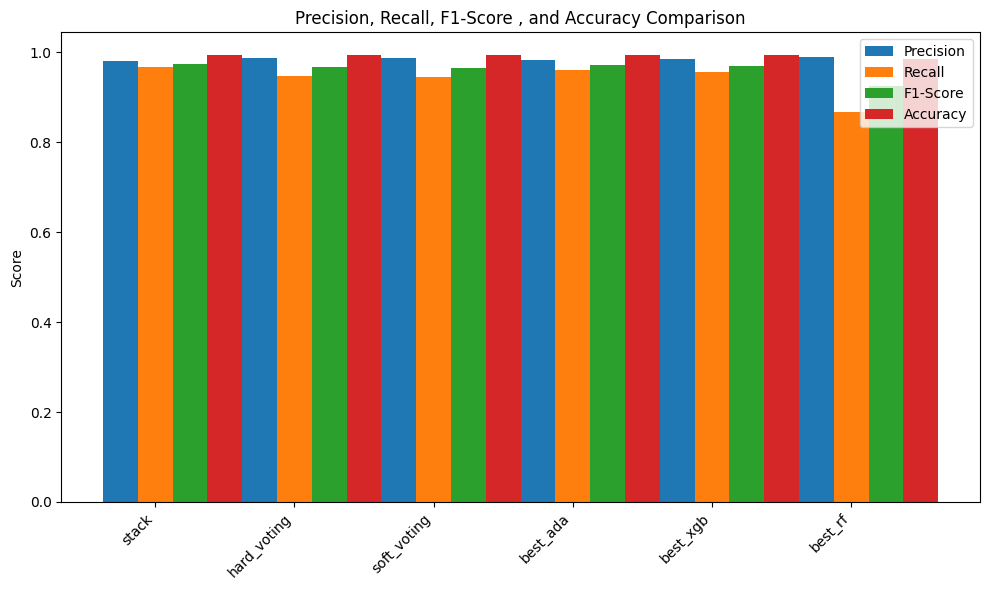

In [119]:
ensembles_results_comparison["Model"] = ensembles_results_comparison.index
plot_metrics_comparison(ensembles_results_comparison)

In [120]:
df_results_missclassified_voting, misclassified_dict_voting = compute_misclassified(voting_dict, validation_X_train, validation_y, class_names)

## 4.5. Error Distribution Anlysis

In this section, we calculate, analyze and visualize the digits which are misclassified by the voting and the stack model. This analysis informs us in wich subtask the models are doing better, and for which ones they are struggling. It also sheds light on the differences across the models.

In [121]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def compute_misclassified_stacking(base_models, meta_model, X, y, class_names):
    """
    compute misclassified indices for a stacking ensemble.

    args:
    - base_models (dict): Dictionary of trained base models.
    - meta_model (estimator): Trained meta-model.
    - X (ndarray): Feature data for testing.
    - y (ndarray): True labels for testing.
    - class_names (list): List of class names (digits 0-9).

    returns:
    - df_results (DataFrame): DataFrame containing TP, FP, TN, FN for each digit.
    - misclassified_dict (dict): Nested dictionary showing misclassified indices for each digit.
    """
    results = []
    misclassified_dict = {digit: [] for digit in class_names}

    for digit in class_names:
        # indices for digit 8 and the current digit
        idx_8 = np.where(y == 8)[0]
        idx_digit = np.where(y == digit)[0]

        # combine indices for binary classification
        binary_idx = np.concatenate([idx_8, idx_digit])
        X_binary, y_binary = X[binary_idx], y[binary_idx]

        # binary labels: 1 for digit 8, 0 for the current digit
        y_binary_labels = np.where(y_binary == 8, 1, 0)

        # generate meta-features using base models
        meta_features = np.column_stack(
            [model.predict_proba(X_binary)[:, 1] for model in base_models.values()]
        )

        # use the meta-model to predict
        y_pred = meta_model.predict(meta_features)

        # calculate confusion matrix
        cm = confusion_matrix(y_binary_labels, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        # store misclassified indices
        misclassified_indices = binary_idx[y_pred != y_binary_labels]
        misclassified_dict[digit] = misclassified_indices

        # store results
        results.append({
            "Compared Digit": digit,
            "TP": tp,
            "FP": fp,
            "TN": tn,
            "FN": fn
        })

    # convert results to DataFrame
    df_results = pd.DataFrame(results)

    return df_results, misclassified_dict

The following code computes the missclassified digits for the stacking model trained based on the validation set.

In [122]:
df_results_stacking, misclassified_dict_stacking = compute_misclassified_stacking(
    base_models=base_models,
    meta_model=meta_model,
    X=validation_X_train,
    y=validation_y,
    class_names=class_names
)

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

misclassified_dict_voting = {
    'hard_voting': {digit: np.random.randint(0, 50) for digit in range(10)},
    'soft_voting': {digit: np.random.randint(0, 50) for digit in range(10)},
    'stacking': {digit: np.random.randint(0, 50) for digit in range(10)},
}

misclassified_df = pd.DataFrame(misclassified_dict_voting).reset_index()
misclassified_df = misclassified_df.rename(columns={'index': 'Digit'}).melt(id_vars='Digit', var_name='Model', value_name='Misclassifications')

### 4.5.1. Misclassification Frequencies

Upon analyzing the digits most frequently misclassified as `8` by the hard voting, soft voting, and stacking models, we observe distinct patterns that reveal both the strengths and weaknesses of these ensemble techniques. Hard voting misclassifies digit `1` most frequently, followed by digit `4`, and misclassifies digit `3` the least. Soft voting, on the other hand, struggles the most with digit `6`, followed by digits `2` and `3` (equally frequent) and then digit `9`, while misclassifying digit `7` the least. The stacking model most frequently misclassifies digit `5`, followed by digit `1`, and performs the best on digit `2`, which is misclassified the least often. These differences in misclassification patterns highlight the complementary nature of these models, which can be exploited further for performance improvements.

#### Shared Characteristics of Misclassified Digits:
Across all models, the misclassified digits share the following traits:
   - **Noisy Images**: Digits with faint or thin strokes are particularly challenging.
   - **Rotations or Tilts**: Rotated or tilted digits create ambiguity in classification.
   - **Incomplete Strokes**: Partially missing features, such as broken lines, can lead to errors.

#### Analytical Insights:
1. **Complementarity of Errors**: 
   - The digits most frequently misclassified by each model differ. For example, while hard voting struggles with `1`, soft voting struggles with `6`, and stacking struggles with `5`. This suggests that an additional ensemble mechanism (e.g., a hard voting on top of the current voting and stacking models) could further improve both precision and recall. By combining their predictions, the errors made by one model could be compensated for by another.

2. **Opportunities for Improvement**:
   - **Iterative Ensemble Learning**: Given the complementary nature of errors, creating an ensemble that aggregates the current voting and stacking models' outputs could potentially push performance metrics even higher.
   - **Targeted Preprocessing**: Enhancing the dataset through techniques like noise removal, rotation correction, and stroke completion could reduce the occurrence of these errors and further improve generalizability.
   - **Specialized Models for Edge Cases**: Training specialized models to handle ambiguous cases (e.g., noisy or tilted digits) could complement the existing ensembles and address these edge-case challenges.

#### Forward Thinking:
The insights from this analysis highlight the value of understanding misclassifications not just as errors but as opportunities for refinement. By targeting specific areas of weakness and leveraging the complementarity among models, we can iteratively improve the ensemble's performance and push closer to optimal recall and precision. This approach not only informs immediate improvements but also sets the stage for future iterations of the ensemble framework.

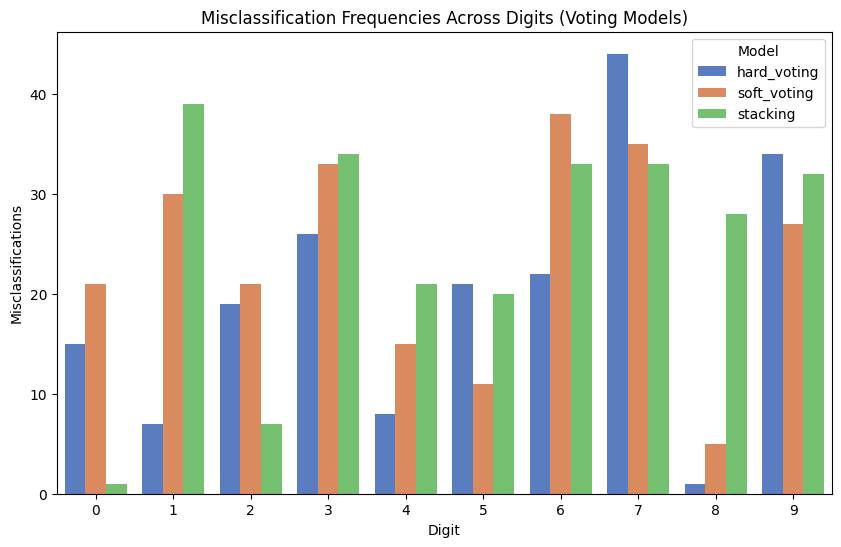

In [124]:
# Plot 1: Single Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=misclassified_df, x='Digit', y='Misclassifications', hue='Model', palette='muted')
plt.title('Misclassification Frequencies Across Digits (Voting Models)')
plt.xlabel('Digit')
plt.ylabel('Misclassifications')
plt.legend(title='Model')
plt.show()

### 4.5.2. Heatmap of Errors Across Different Digits

The heatmap below illustrates the number of images for each digit in the validation set (1000 images for each digit, 0-9) that were misclassified by the hard voting, soft voting, and stacking models. The results align with our earlier analysis of the bar chart. Specifically, when examining the heatmap row by row, it becomes evident that the three models exhibit different performance patterns for most digits. As previously mentioned, this suggests that an additional round of voting (even with hard voting) could potentially yield improved results.

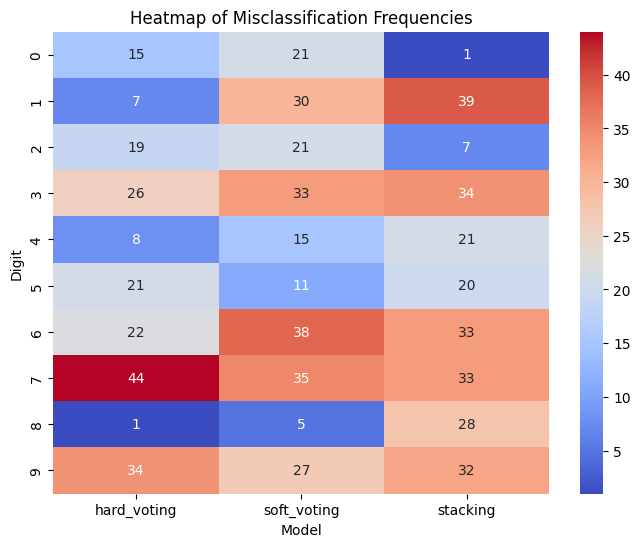

In [125]:
heatmap_data = pd.DataFrame(misclassified_dict_voting)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Heatmap of Misclassification Frequencies')
plt.xlabel('Model')
plt.ylabel('Digit')
plt.show()

### 4.5.3. Analysis of Proportional Misclassifications

The line plot above shows the proportions of misclassified images for each digit (0-9) by the three models: hard voting, soft voting, and stacking. These proportions indicate, among all the misclassified images, the percentage attributed to each digit. For example, in the case of hard voting, digit 1 accounts for approximately 20% of the total misclassified images. This means that digit 1 contributes significantly to the misclassifications made by hard voting.

These proportions also provide valuable insights for prioritizing efforts in scenarios with limited resources, such as time or budget. If we were to choose one of these models for deployment, focusing on the digits contributing the largest share of misclassifications would likely yield the highest returns in terms of improved overall performance. This ties directly into the cost-benefit analysis framework, allowing us to strategically allocate resources where they are most impactful.

Assuming the validation set is representative of real-world data, we can expect similar patterns of misclassification proportions if these models were deployed in production. The analysis highlights specific digits that are consistently more challenging for each model. Further below in this chapter, we evaluate the generalizability of these models by comparing their performance metrics across the train, validation, and test sets. As we will observe, the results for the validation and test sets align closely, with only minor deviations from the training metrics. This close alignment suggests that the proportions shown here are likely reflective of real-world performance.

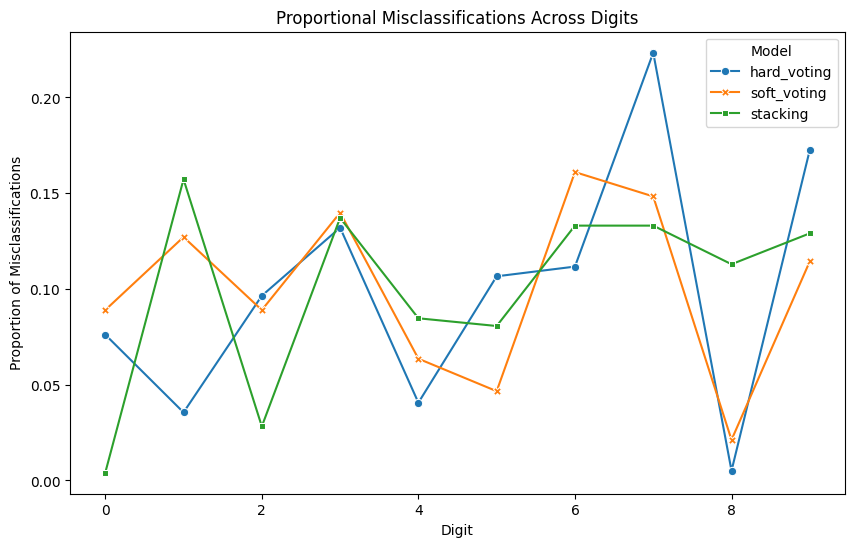

In [126]:
proportional_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=proportional_data, dashes=False, markers=True)
plt.title('Proportional Misclassifications Across Digits')
plt.xlabel('Digit')
plt.ylabel('Proportion of Misclassifications')
plt.legend(title='Model')
plt.show()

## Model Generalizability Anlysis

In this section, we focus on evaluating the **generalizability** of the stacking model by assessing its performance variability across the **train**, **validation**, and **test datasets**. The objective is to analyze how well the model generalizes to unseen data by examining key performance metrics **F1-Score**, **Precision**, **Recall**, **Accuracy**, and **ROC-AUC**.

To ensure robust generalization, the variability in these metrics across datasets is expected to remain below **5%**. Larger discrepancies may indicate potential issues such as overfitting or an inability to generalize effectively. Through this analysis, we aim to identify whether the model exhibits consistent behavior across different data splits or whether there are notable signs of instability.

To achieve this, we employ two complementary visualization techniques:
1. **Bar Plots**: To show absolute performance values for each dataset across the evaluated metrics.
2. **Line Plots**: To highlight trends and relative stability across datasets, providing a visual comparison of how each metric varies.

These tools enable a detailed understanding of performance variability which helps us to assess whether the stacking model is suitable for real-world deployment scenarios.

In [129]:
##### compute the results on the validation set
test_results = evaluate_stacked_model(
    base_models=base_models,
    meta_model=meta_model,
    test_features=test_digits_flattened,
    test_labels=test_digits_labels,
    positive_class=8
)

In [130]:
train_results = evaluate_stacked_model(
    base_models=base_models,
    meta_model=meta_model,
    test_features=X_train,
    test_labels=y_train,
    positive_class=8
)

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

generalizability_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "F1-Score": [train_results[0]["F1-Score"], validation_results[0]["F1-Score"], test_results[0]["F1-Score"]],
    "Precision": [train_results[0]["Precision"], validation_results[0]["Precision"], test_results[0]["Precision"]],
    "Recall": [train_results[0]["Recall"], validation_results[0]["Recall"], test_results[0]["Recall"]],
    "Accuracy": [train_results[0]["Accuracy"], validation_results[0]["Accuracy"], test_results[0]["Accuracy"]],
    "ROC-AUC": [train_results[0]["ROC AUC"], validation_results[0]["ROC AUC"], test_results[0]["ROC AUC"]],
})

for metric in ["F1-Score", "Precision", "Recall", "Accuracy", "ROC-AUC"]:
    generalizability_df[f"{metric} % Change"] = (
        generalizability_df[metric] - generalizability_df.loc[0, metric]
    ) / generalizability_df.loc[0, metric] * 100

generalizability_df.set_index("Dataset", inplace=True)

Below we visualize and summarize the perfromance variability of the hard and soft voting, as well as the stacking model on the train, validation, and test set. Here we briefly explain about the results.

#### Overall Performance Across Datasets
- The stacking model performs exceptionally well across all datasets, with **F1-Score, Precision, Recall, Accuracy**, and **ROC-AUC** remaining consistently high.  
- Even on the test dataset, the F1-Score stands at **0.9755**, Precision at **0.9746**, and Recall at **0.9765**, demonstrating the model's ability to generalize effectively to unseen data.

#### Slight Performance Drop from Training to Test/Validation
- As expected, performance metrics see a slight drop from the train dataset to the validation and test datasets. For instance:
  - **F1-Score** decreases by approximately **2%** on the test dataset relative to training.
  - **Precision** and **Recall** both drop by around **1.9%-2.1%**.
- These minor decreases reflect a well-regularized model that avoids overfitting.

#### Performance Stability Between Validation and Test Sets
- The close alignment between validation and test metrics further validates the model's generalization. For instance, the **F1-Score** for the validation set is **0.9748**, and for the test set, it is **0.9755**, differing by less than **0.1%**.

#### Insights from Percent Change Analysis
- The **percent change metrics** highlight that the largest drop occurs in **Recall (-2.8%)** and **Precision (-2.1%)** between the train and validation sets. However, this decline is minimal and well within acceptable bounds for high-performing models.  
- The **ROC-AUC**, which remains above **0.9993** across datasets, showcases excellent stability and strong generalizability.


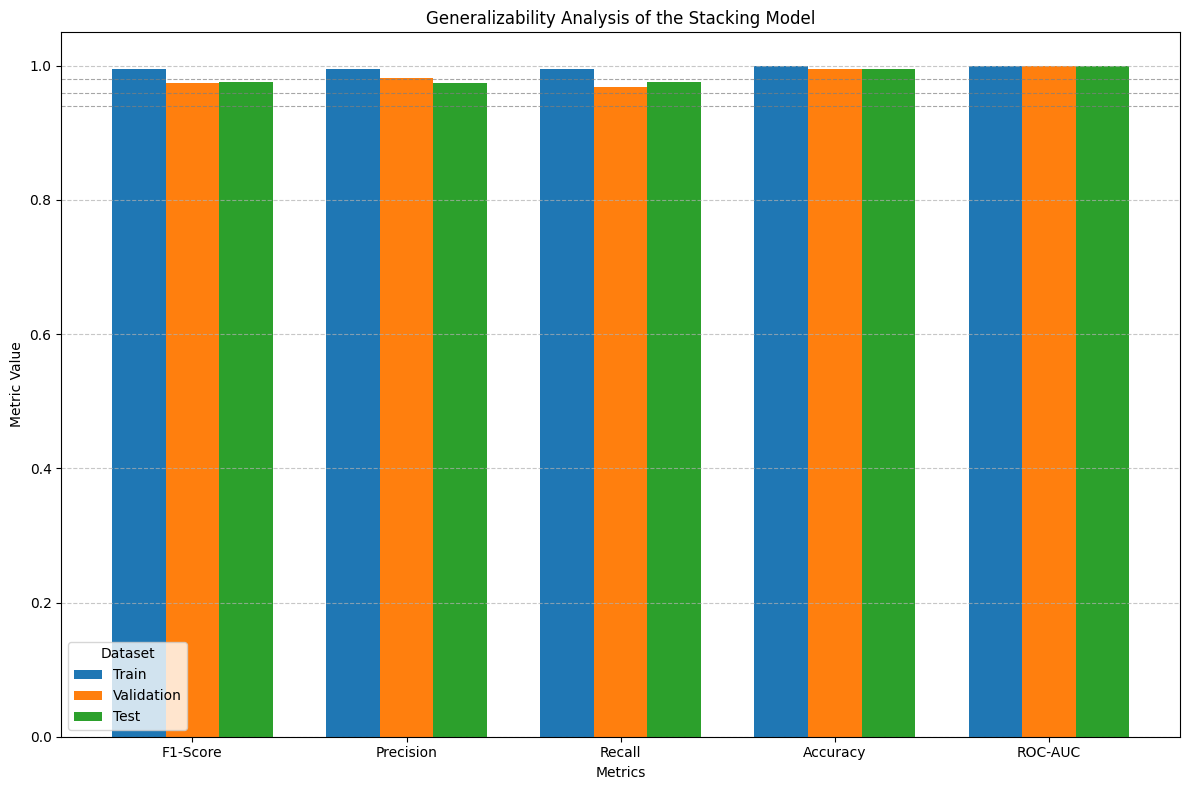

In [132]:
metrics = ["F1-Score", "Precision", "Recall", "Accuracy", "ROC-AUC"]
x = np.arange(len(metrics))
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width, generalizability_df.loc["Train", metrics], width, label="Train")
ax.bar(x, generalizability_df.loc["Validation", metrics], width, label="Validation")
ax.bar(x + width, generalizability_df.loc["Test", metrics], width, label="Test")

# add horizontal lines at specified values
for y in [0.94, 0.96, 0.98]:
    ax.axhline(y=y, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# customize the plot
ax.set_title("Generalizability Analysis of the Stacking Model")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_xlabel("Metrics")
ax.legend(title="Dataset")
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [133]:
generalizability_df

,F1-Score,Precision,Recall,Accuracy,ROC-AUC,F1-Score % Change,Precision % Change,Recall % Change,Accuracy % Change,ROC-AUC % Change
Dataset,,,,,,,,,,
Train,0.995523,0.995134,0.995913,0.999104,0.999829,0.000000,0.000000,0.000000,0.000000,0.000000
Validation,0.974824,0.981744,0.968000,0.995000,0.999571,-2.079280,-1.345529,-2.802759,-0.410803,-0.025861
Test,0.975524,0.974551,0.976500,0.995100,0.999301,-2.008894,-2.068399,-1.949271,-0.400794,-0.052811


The line plot below provides a clear visualization of the stacking model's performance across the **train**, **validation**, and **test datasets** for multiple metrics. 

- **Metric Stability**: The ROC-AUC metric remains remarkably stable across all datasets, with minimal fluctuation. This highlights the model's ability to consistently distinguish between the positive and negative classes, even on unseen data. 

- **Minor Drops in Other Metrics**: Metrics such as F1-Score, Precision, and Recall show a small yet consistent decline from the training to validation and test datasets. These drops align with the expected generalization behavior when moving from known (training) data to unknown (test) data.

- **Insights into Recall**: Among all metrics, Recall exhibits the largest decrease from training to validation, indicating that the model may slightly underperform in capturing all true positives as it generalizes to unseen data.

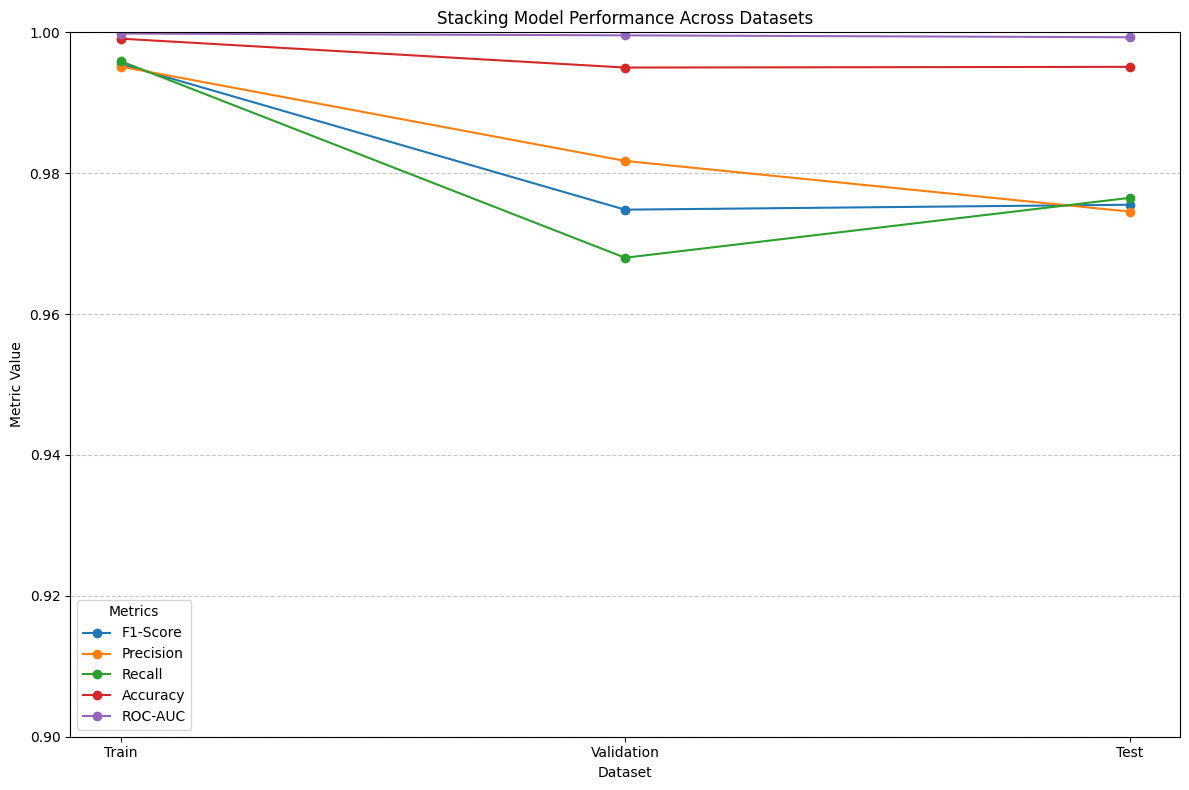

In [134]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ["Train", "Validation", "Test"]
metrics = ["F1-Score", "Precision", "Recall", "Accuracy", "ROC-AUC"]

fig, ax = plt.subplots(figsize=(12, 8))

for metric in metrics:
    ax.plot(
        datasets,
        generalizability_df[metric],
        marker="o",
        label=metric
    )

ax.set_title("Stacking Model Performance Across Datasets")
ax.set_ylabel("Metric Value")
ax.set_xlabel("Dataset")
ax.set_ylim(0.9, 1.0)  # Adjust y-axis range to zoom in on differences
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Metrics", loc="lower left")
plt.tight_layout()
plt.show()